In [128]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Sat Nov 18 11:10:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:00:05.0 Off |                  N/A |
|  0%   26C    P8    24W / 350W |    830MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:00:06.0 Off |                  N/A |
|  0%   

In [118]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = "cuda"

In [64]:
import torch
import sklearn
import transformers
import pytorch_lightning as pl

import torch.nn as nn
import torch.nn.functional as F

from sklearn import metrics
from transformers import AutoTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [65]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

def create_classification_dataset(df, tokenizer, max_len=512, test_size=0.2, random_state=42):
    labels = df['Suspicious_Level'].astype(int)
    texts = df['Content'].astype(str)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=random_state
    )

    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_len)
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=max_len)

    train_dataset = CustomDataset(train_encodings, torch.tensor(train_labels.values, dtype=torch.long))
    val_dataset = CustomDataset(val_encodings, torch.tensor(val_labels.values, dtype=torch.long))

    return train_dataset, val_dataset

In [48]:
train_df = pd.read_csv("train.csv")
train_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1
3,boris_rozhin,1101806611,91573,2023-07-08 02:07:05,2023-07-08 02:07:19,МТ-ЛБ с 32-зарядной авиационной пусковой устан...,1
4,swodki,1144180066,280695,2023-07-09 07:01:49,2023-07-09 07:05:08,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1


In [49]:
train_df.shape

(587, 7)

In [30]:
test_df = pd.read_csv("test.csv")
test_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content
0,ukraina_ru,1175084215,168641,2023-09-11 16:57:36,2023-09-11 16:57:50,"⚡️Администрация Байдена близка к тому, чтобы о..."
1,bear007,1505866568,36569,2023-09-11 14:52:01,2023-09-11 14:52:12,РИА Новости публикует первые кадры с места гиб...
2,zakharprilepin,1217080686,19697,2023-09-11 08:26:09,NaN,Вице-спикер Госдумы Петр Толстой - о сроках ок...
3,denazi_ua,1783083983,49296,2023-09-11 12:30:37,2023-09-11 12:32:55,В Германии не осталось действующих специалисто...
4,spletnicca,1287596810,11784,2023-09-11 08:47:19,NaN,Военные медики рассказали правду о войне и её ...


In [31]:
test_df.shape

(1171, 6)

In [46]:
unsupervised_df = pd.read_csv("unsupervised_data.csv")
unsupervised_df.head()

In [33]:
unsupervised_df.shape

(15681881, 3)

In [34]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,MessageId,Suspicious_Level
0,168641,1
1,36569,1
2,19697,1
3,49296,1
4,11784,1


1. Masked pretrained on unsupervised data
2. Train on emnlp 
    1? adapt labels from original task -> to ours
    2? train on original task of emnlp
3. Engineer synthetic data
4. Train on train.csv

In [66]:
tokenizer = AutoTokenizer.from_pretrained(
    "ai-forever/ruBert-base", cache_dir=".")

In [68]:
tokenizer

BertTokenizerFast(name_or_path='ai-forever/ruBert-base', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [67]:
class RegressionBERT(pl.LightningModule):
    def __init__(
        self, 
        num_classes: int = 3, 
        dropout_prob: float = 0.5,
        learning_rate: float = 1e-5, 
    ):
        super(RegressionBERT, self).__init__()

        self.learning_rate = learning_rate

        self.model = BertModel.from_pretrained("ai-forever/ruBert-base", cache_dir=".")

        d1 = torch.nn.Dropout(dropout_prob)
        l1 = torch.nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        d2 = torch.nn.Dropout(dropout_prob)
        l2 = torch.nn.Linear(self.model.config.hidden_size, num_classes)

        self.classification_head = nn.Sequential(*[d1, l1, d2, l2])
        
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.classification_head(pooled_output)
        
        return output.squeeze(1)

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        predictions = self(input_ids, attention_mask)
        loss = self.loss_fn(predictions, labels)
        
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        predictions = self(input_ids, attention_mask)
        loss = self.loss_fn(predictions, labels)
        return {"val_loss": loss, "predictions": predictions, "labels": labels}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer


In [69]:
train, val = create_classification_dataset(train_df, tokenizer)

In [72]:
module = RegressionBERT()

In [77]:
input_ids, token_type_ids, attention_mask, label = train[0].values()

In [100]:
output = module(input_ids[None], attention_mask[None])
output

tensor([[-0.1493, -0.0810,  0.2197]], grad_fn=<SqueezeBackward1>)

In [101]:
module.loss_fn(output, label[None])

tensor(1.1893, grad_fn=<NllLossBackward0>)

In [10]:
f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')

NameError: name 'y_true' is not defined

In [106]:
df = pd.read_csv("test.csv")

In [107]:
df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content
0,ukraina_ru,1175084215,168641,2023-09-11 16:57:36,2023-09-11 16:57:50,"⚡️Администрация Байдена близка к тому, чтобы о..."
1,bear007,1505866568,36569,2023-09-11 14:52:01,2023-09-11 14:52:12,РИА Новости публикует первые кадры с места гиб...
2,zakharprilepin,1217080686,19697,2023-09-11 08:26:09,NaN,Вице-спикер Госдумы Петр Толстой - о сроках ок...
3,denazi_ua,1783083983,49296,2023-09-11 12:30:37,2023-09-11 12:32:55,В Германии не осталось действующих специалисто...
4,spletnicca,1287596810,11784,2023-09-11 08:47:19,NaN,Военные медики рассказали правду о войне и её ...


In [108]:
df = df.drop(columns=["ChannelId", "ChannelName", "Date", "EditDate"])

In [109]:
df.head()

,MessageId,Content
0,168641,"⚡️Администрация Байдена близка к тому, чтобы о..."
1,36569,РИА Новости публикует первые кадры с места гиб...
2,19697,Вице-спикер Госдумы Петр Толстой - о сроках ок...
3,49296,В Германии не осталось действующих специалисто...
4,11784,Военные медики рассказали правду о войне и её ...


In [119]:
from train import DisinformationBERT
model = DisinformationBERT.load_from_checkpoint("/mnt/vol_d/bh/checkpoints/epoch=14-val_loss=0.94.ckpt")

In [120]:
train_encodings = model.tokenizer(list(df["Content"]), truncation=True, padding=True, max_length=512)

In [126]:
predictions = []
for idx in range(df.shape[0]):
    input_ids = torch.tensor(train_encodings["input_ids"][idx], device=device).unsqueeze(0)
    attn_mask = torch.tensor(train_encodings["attention_mask"][idx], device=device).unsqueeze(0)

    print(input_ids.shape, attn_mask.shape)

    with torch.no_grad():
        pred = model(
            torch.tensor(train_encodings["input_ids"][idx], device=device).unsqueeze(0),
            attention_mask=torch.tensor(train_encodings["attention_mask"][idx], device=device).unsqueeze(0)
        )

    pred = torch.argmax(pred, dim=1).item()

    predictions.append(pred)

torch.Size([1, 512]) torch.Size([1, 512])
0


(array([383.,   0.,   0.,   0.,   0., 139.,   0.,   0.,   0.,  65.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

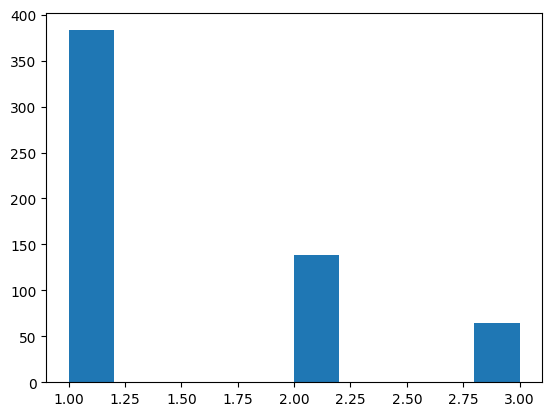

In [129]:
plt.hist(train_df["Suspicious_Level"])